In [1]:
import pandas as pd 
import numpy as np

# for timestamps
from datetime import datetime
from datetime import timedelta

# imports to find autocorrelation plots
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# imports for partial correlation plots
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

#decomposing time series
from statsmodels.tsa.seasonal import seasonal_decompose

# for plotting
import matplotlib.pyplot as plt

#for adfuller test
from statsmodels.tsa.stattools import adfuller

# for performance metrics
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline

## For these exercises There will be a demo forecasting the Stock Volume then you will develop a model for one of the other columns independantly

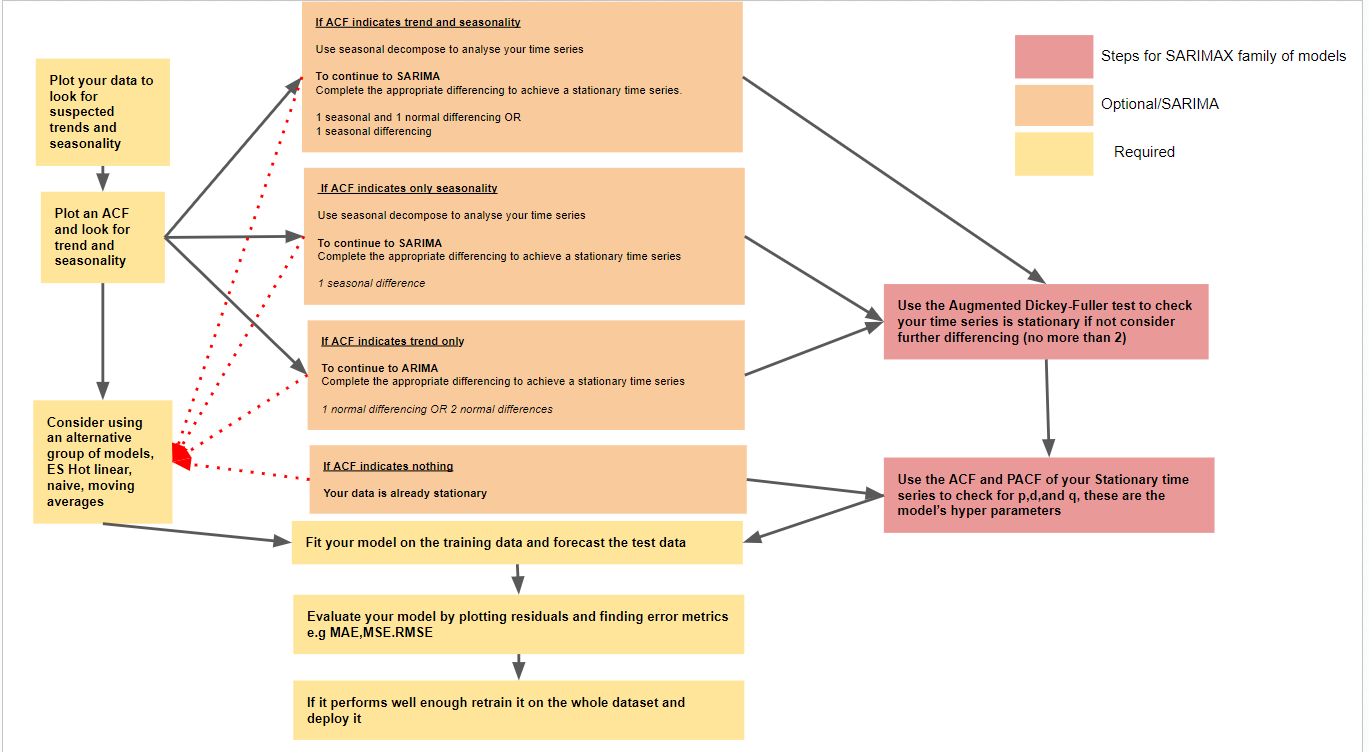

## Creating ARIMA models


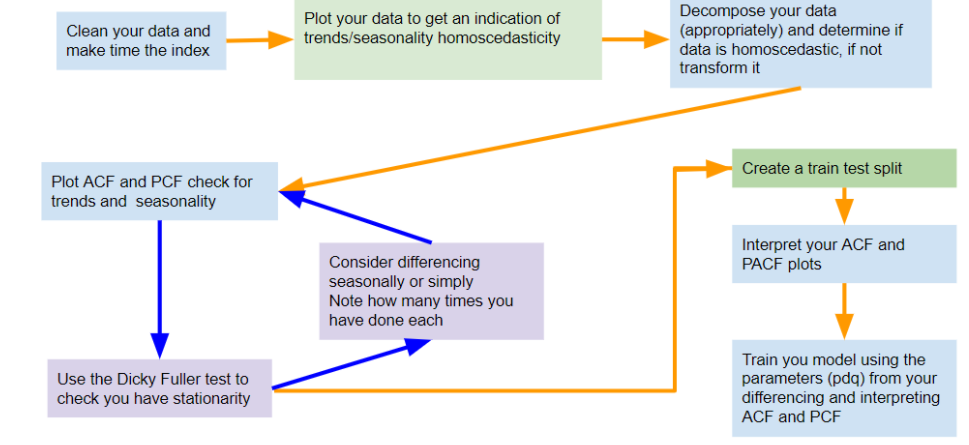

In [3]:
# let's get some data

path = 'data/bus.csv'
bus = pd.read_csv(path)
bus.tail()

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327
114,NaN,NaN
115,Portland Oregon average monthly bus ridership ...,n=114


## 1. Cleaning

In [4]:
bus.columns= ['Month','riders']

In [5]:
bus.head(10)

# check for nulls
bus.isnull().sum().sum()

2

In [6]:
bus.isnull().sum()

Month     1
riders    1
dtype: int64

In [7]:
# drop by selecting everything but last row
bus = bus.iloc[:110,:]
bus.isnull().sum().sum()

0

In [8]:
# No nulls left

## 2. Set time as index 

In [9]:
#convert Date to datetime
bus['Month'] = pd.to_datetime(bus['Month'])

In [10]:
bus.dtypes

Month     datetime64[ns]
riders            object
dtype: object

In [11]:
# standard change of index
bus.set_index('Month', inplace=True)

bus = bus.sort_index()
# we could set the frequency to business days as we have no weekend data!
# you can also use resample('B') to get the same effect
bus = bus.resample("M").pad()

bus.head()

,riders
Month,
1960-01-31,648
1960-02-29,646
1960-03-31,639
1960-04-30,654
1960-05-31,630


In [12]:
# resampling has introduced some nulls
bus.isnull().sum().sum()

0

In [13]:
# use fillna to fill in nulls if we have them and make sure we have regular intervals
bus.fillna(method='pad', inplace=True)

In [14]:
# use index to check the frequency of your timeseries, this can indicate if Pandas is having any trouble 
# detecting the interval between measurements
bus.index

DatetimeIndex(['1960-01-31', '1960-02-29', '1960-03-31', '1960-04-30',
               '1960-05-31', '1960-06-30', '1960-07-31', '1960-08-31',
               '1960-09-30', '1960-10-31',
               ...
               '1968-05-31', '1968-06-30', '1968-07-31', '1968-08-31',
               '1968-09-30', '1968-10-31', '1968-11-30', '1968-12-31',
               '1969-01-31', '1969-02-28'],
              dtype='datetime64[ns]', name='Month', length=110, freq='M')

In [15]:
bus.head()

,riders
Month,
1960-01-31,648
1960-02-29,646
1960-03-31,639
1960-04-30,654
1960-05-31,630


In [16]:
bus.dtypes

riders    object
dtype: object

In [17]:
# convert the riders column to numerical
# notice no use of lambda here! we can give a function name minus paranthesis and apply will apply it to our data
# for more complex changes write your own function
bus['riders'] = bus['riders'].apply(int)
bus.dtypes

riders    int64
dtype: object

## 3. Plot your timeseries to see if it has a trend or seasonality

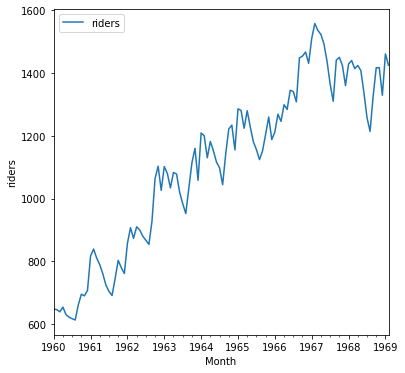

In [18]:
plt.rcParams["figure.figsize"] = [6,6]

ax = bus.plot(y = 'riders',use_index = True)
ax.set_xlabel("Month")
ax.set_ylabel("riders");

## 4. Decompose


REMEMBER if you don't have seasonality decompose by finding the MA and subtracting it from the data, OR by fitting a polynomial line and subtracting it this will give you the residual.

<Figure size 432x432 with 0 Axes>

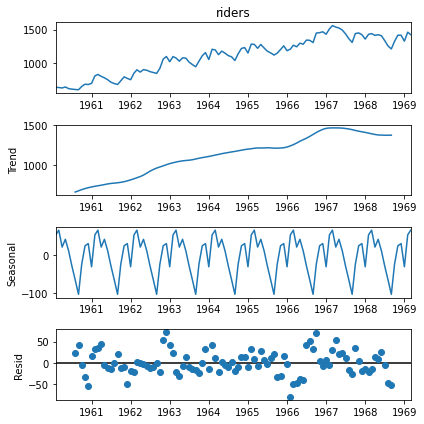

In [19]:
decomposition = seasonal_decompose(bus['riders'], period = 12)  
fig = plt.figure()  
fig = decomposition.plot()

In [20]:
# Looks like we have a large trend and seasonality
# thankfull though it is homoscedastic!

In [21]:
#Dicky Fuller to check stationarity

stationary_test = adfuller(bus['riders'])
# looks like we don't have a stationary timeseries as the p-value is < 0.05

stationary_test[1]

# we could already tell that it wasn't stationary

0.5738063879272244

## 5. Acheive stationarity

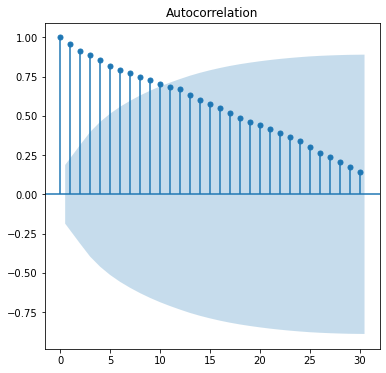

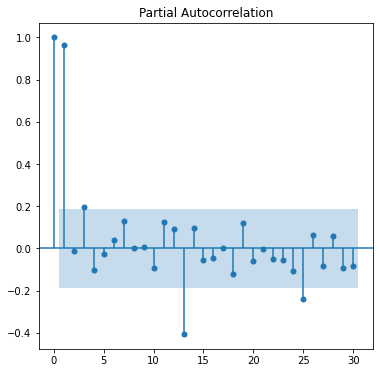

In [22]:
plot_acf(bus['riders'],lags=30);
plot_pacf(bus['riders'],lags = 30);

In [23]:
# looks like seasonality is present but the trend is really clear in the ACF 
# apply differencing
bus['sdifferenced'] = bus['riders'].diff(12)
bus.head()

,riders,sdifferenced
Month,,
1960-01-31,648,NaN
1960-02-29,646,NaN
1960-03-31,639,NaN
1960-04-30,654,NaN
1960-05-31,630,NaN


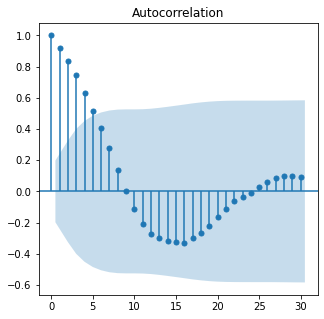

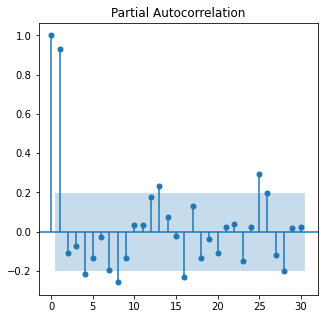

In [24]:
dif = bus['sdifferenced'].dropna()
# plot the ACF and PCF
fig, ax = plt.subplots(figsize=(5, 5))
plot_acf(dif,lags=30, ax=ax);
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
plot_pacf(dif,lags = 30, ax =ax);
plt.show()

In [25]:
#Dicky Fuller to check stationarity

stationary_test = adfuller(dif)
# looks like we have a stationary timeseries as the p-value is < 0.05

stationary_test[1]

0.015016298980200123

In [26]:
# we could difference on more time but we may over-difference
bus['sandndifferenced'] = bus['sdifferenced'].diff()
bus.head()

,riders,sdifferenced,sandndifferenced
Month,,,
1960-01-31,648,NaN,NaN
1960-02-29,646,NaN,NaN
1960-03-31,639,NaN,NaN
1960-04-30,654,NaN,NaN
1960-05-31,630,NaN,NaN


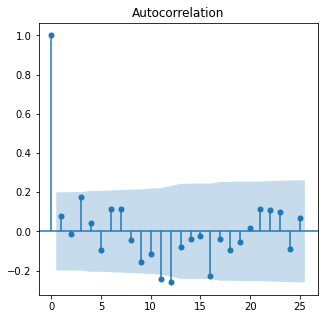

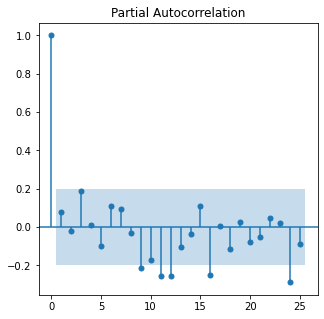

In [27]:
over_dif = bus['sandndifferenced'].dropna()

fig, ax = plt.subplots(figsize=(5, 5))
plot_acf(over_dif,lags=25, ax = ax);
plt.show()



fig, ax = plt.subplots(figsize=(5, 5))
plot_pacf(over_dif,lags = 25, ax = ax);
plt.show()

## 6. Train test split

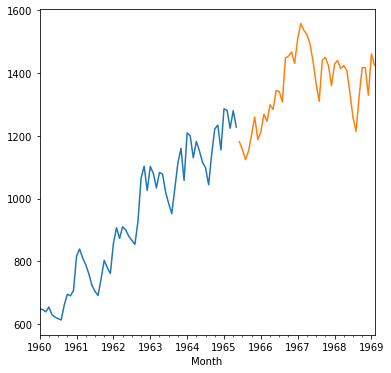

In [28]:
train_size = 65

# notice we use the transformed data(logged data) to input in to our model 
# we will have to account for this later by reversing it.
train = bus['riders'][:train_size]
test = bus['riders'].iloc[train_size:]
# note depending on which way your dates are 
# sorted this may need changing

# visualise the train-test split to check it seems reasonable
fig, ax = plt.subplots(1, 1)
train.plot(ax=ax);
test.plot(ax=ax);
plt.show();

# IF you transform you timeseries you must use the transformed version to train the model
# blue is training data orange is testing data

## 7. Interpret ACF and PACF to find pdq and s(pdqs) terms
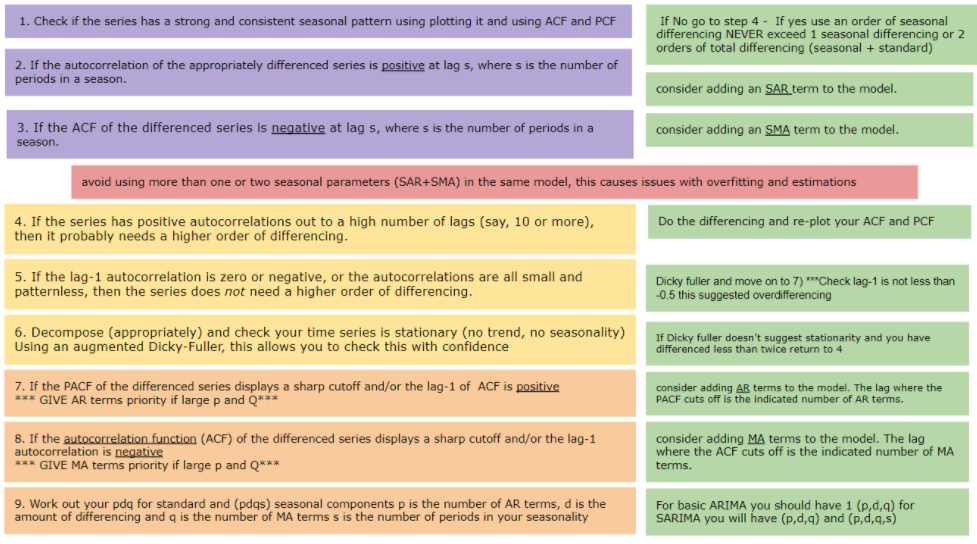

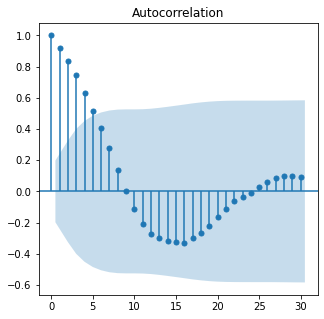

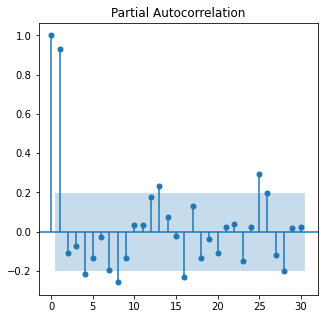

In [29]:
# plot the ACF and PCF
fig, ax = plt.subplots(figsize=(5, 5))
plot_acf(dif,lags=30, ax=ax);
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
plot_pacf(dif,lags = 30, ax =ax);
plt.show()

### No SAR terms or SMA needed 1 differencing so pdqs = (0,1,0,12)
### AR terms have priority because first PACF is positive
### AR1 is the only significant lag so pdq = (1,0,0)

## Let's interpret the other ACF and PCF

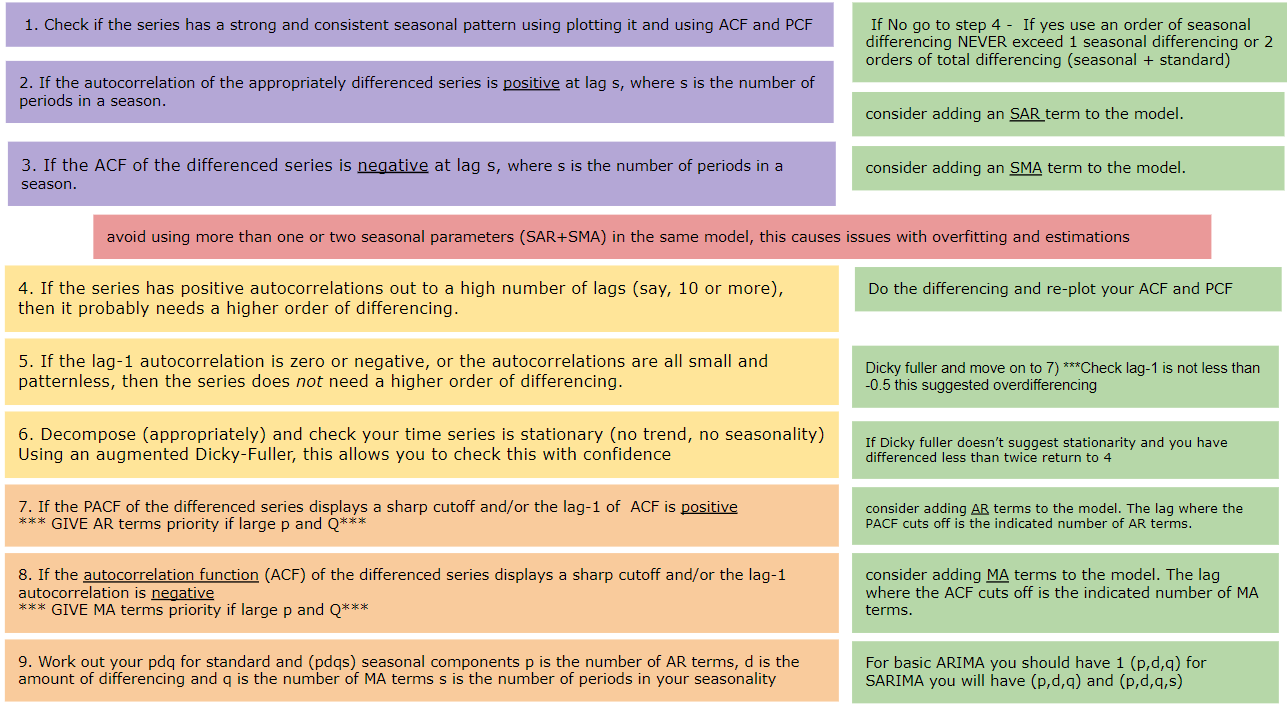

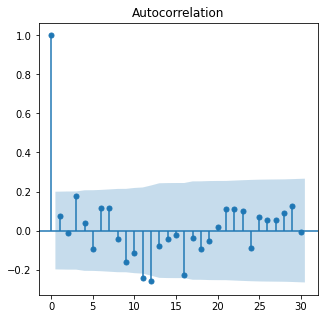

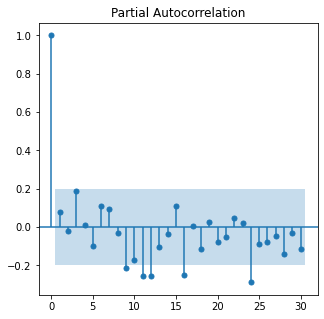

In [30]:
# plot the ACF and PCF
fig, ax = plt.subplots(figsize=(5, 5))
plot_acf(over_dif,lags=30, ax=ax);
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
plot_pacf(over_dif,lags = 30, ax =ax);
plt.show()

### No SAR terms or SMA needed, 1 differencing so pdqs = (0,1,0,12)
### No AR or MA terms but 1 differencing so pdq = (0,1,0)

## 8. Build model

In [38]:
# building the model is easy we just input our pdq and pdqs in to the SARIMAX model.
# Note to turn the SARIMAX into an ARIMA for non-seasonal data use fit1 = SARIMAX(train, order=(0,1,1)).fit()
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

test_size = len(bus.index) - train_size


# fit the models
fit_dif = SARIMAX(train, order=(0,0,0), seasonal_order=(0,1,0,12)).fit()
fit_over_dif = SARIMAX(train, order=(0,1,0), seasonal_order=(0,1,0,12)).fit()


# create the forecast
forecast1 = fit_dif.get_forecast(test_size).summary_frame(alpha=0.1)
forecast2 = fit_over_dif.get_forecast(test_size).summary_frame(alpha=0.1)



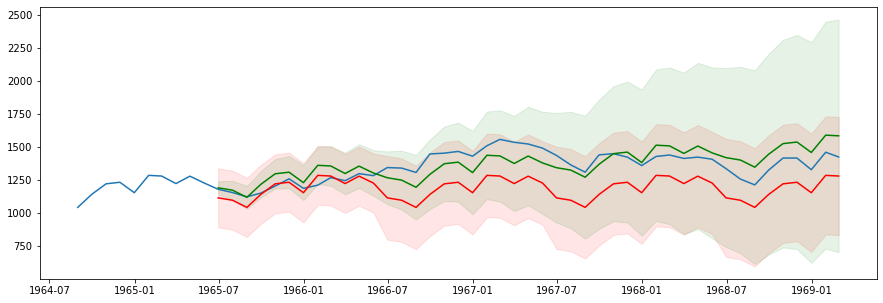

In [39]:
# for the twice_differenced model
fig, ax = plt.subplots(figsize=(15, 5))

# plot the original data
ax.plot(bus.index[train_size-10:], bus['riders'][train_size-10:])

# plot the forecasts
ax.plot(bus.index[-test_size:], forecast1['mean'], color = 'r')
ax.plot(bus.index[-test_size:], forecast2['mean'], color = 'g')

# plot the confidence intervals on the forecasts
ax.fill_between(bus.index[-test_size:], forecast1['mean_ci_lower'], forecast1['mean_ci_upper'], color='r', alpha=0.1);
ax.fill_between(bus.index[-test_size:], forecast2['mean_ci_lower'], forecast2['mean_ci_upper'], color='g', alpha=0.1);


## 9. Evaluate the performance

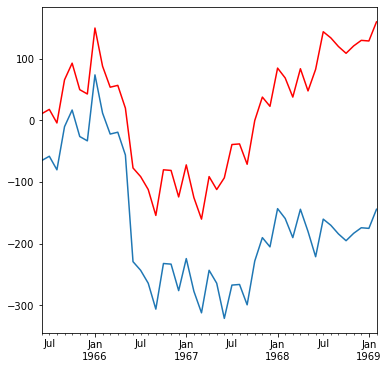

In [40]:
# Take the residuals of your prediction vs the actual values
# if the model has captured all of the signal the residuals will just look like random noise

resid1 = forecast1['mean'] - test
resid1.plot();

resid2 = forecast2['mean'] - test
resid2.plot(color = 'r');

In [34]:
# the residual for the more differenced model performed better as the residuals 
# have a mean around zero and no trend they appear more like white noise

In [42]:
a = mean_squared_error(test, forecast1['mean'])
b = mean_squared_error(test, forecast1['mean'], squared = False)

c = mean_squared_error(test, forecast2['mean'])
d = mean_squared_error(test, forecast2['mean'], squared = False)



print(f'model 1 with 2 levels seasonal differencing only, had an mse of: {a} and an RMSE of: {b}\n\n')
print(f'model 2 with 1 levels of differencing had an mse of: {c} and an RMSE of: {d}')

model 1 with 2 levels seasonal differencing only, had an mse of: 38394.64444444444 and an RMSE of: 195.94551396866538


model 2 with 1 levels of differencing had an mse of: 8616.155555555179 and an RMSE of: 92.82324900344298
